In [1]:
import math
import numpy as np
import scipy as sp
from scipy.linalg import eig
from numpy import sin, cos, abs, exp, sqrt, arccos, pi
from scipy.sparse import csc_matrix

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
U = 0.5 # Kerr non-linearity
gamma = 5e-2 # Loss rate
J = 1.0 # Tunneling
N = 50 # Number of cavities in the vertical direction
M = 50 # Number of cavities in the horizontal direction

F_list = np.sqrt(np.linspace(0.01, 2, 24)*J**3/U) # Pump
Delta_list = np.linspace(-2, 2, 24) # Detuning

In [3]:
T = np.zeros((N, M, N, M), dtype=np.float64)

for j in range(N):
    for k in range(M-1):

        T[j, k+1, j, k] = J
        T[j, k, j, k+1] = J

for j in range(N-1):
    for k in range(M):

        T[j+1, k, j, k] = J
        T[j, k, j+1, k] = J

In [4]:
def f_RK4(Delta, U, gamma, F, a):

    y = -1.0j * (
        -Delta*a + U*abs(a)**2*a + np.einsum('nmjk,jk->nm', T, a) - 1.0j*gamma*a + F
    )
    
    return y

N_t = 1e3 # Number of time steps
t_f = 1e2 # Final time
t = np.linspace(0, t_f, int(N_t))
Delta_t = t[1] - t[0]

In [27]:
ll_list = []
I_T_list = []

# Cavity fields
a = np.zeros((N, M, int(N_t)), dtype=np.complex128)

count = 0

for F_i in F_list:

    print('==========> F = {:}'.format(F_i))

    # Cavity-laser coupling
    F = np.zeros((N, M), dtype=np.complex128)
    # F[int(N/2-1), int(M/2-1)] = 1.0 # Central pump
    # Localization
    F[int(N/2), int(M/2-1)] = F_i
    F[int(N/2-1), int(M/2)] = F_i
    F[int(N/2), int(M/2+1)] = F_i
    F[int(N/2+1), int(M/2)] = F_i

    ll_F = []
    I_T_F = []

    for Delta in Delta_list:

        #print('Delta = {:}'.format(Delta))

        for i_t in range(len(t)-1):

            k1 = f_RK4(Delta, U, gamma, F, a[:, :, i_t])
            k2 = f_RK4(Delta, U, gamma, F, a[:, :, i_t] + k1*Delta_t/2)
            k3 = f_RK4(Delta, U, gamma, F, a[:, :, i_t] + k2*Delta_t/2)
            k4 = f_RK4(Delta, U, gamma, F, a[:, :, i_t] + k3*Delta_t)

            a[:, :, i_t+1] = a[:, :, i_t] + (k1 + 2*k2 + 2*k3 + k4)*Delta_t/6

        # We define a parameter characterizing the light localization
        ll = np.abs(a[int(N/2), int(M/2), -1])**2 / np.sum(np.abs(a[:, :, -1])**2)
        ll_F.append(ll)
        
        I_T_F.append( np.sum(np.abs(a[:, :, -1])**2) )
        
    ll_list.append(ll_F)
    I_T_list.append(I_T_F)

==========> F = 0.1414213562373095
==========> F = 0.43936713379686193
==========> F = 0.6050512015703623
==========> F = 0.7342550202638104
==========> F = 0.8439039714585294
==========> F = 0.9408599211914321
==========> F = 1.028718070982141
==========> F = 1.1096415402399493
==========> F = 1.1850518242199186
==========> F = 1.2559423969067316
==========> F = 1.3230399777061523
==========> F = 1.386895187413081
==========> F = 1.4479370632491022
==========> F = 1.506507622745834
==========> F = 1.5628847352419097
==========> F = 1.6172978000087195
==========> F = 1.6699388168953715
==========> F = 1.7209704037068105
==========> F = 1.7705317304967039
==========> F = 1.8187429964006794
==========> F = 1.8657088640024713
==========> F = 1.9115211334113629
==========> F = 1.9562608521715938
==========> F = 2.0


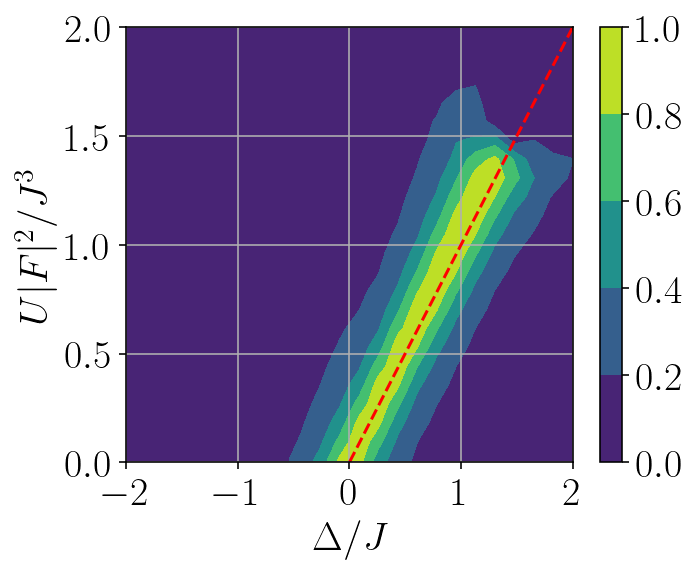

In [21]:
plt.rcParams["figure.figsize"] = [5, 4]
fig, ax = plt.subplots(1, 1)
fs = 20

cp = ax.contourf(Delta_list, U*F_list**2/J**3, ll_list, levels=np.arange(0, 1+0.2, 0.2))
cbar = fig.colorbar(cp, ticks=np.arange(0, 1+0.2, 0.2))
cbar.ax.tick_params(labelsize=fs)

ax.set_xticks([-2, -1, 0, 1, 2])

ax.set_xlabel(r'$\Delta/J$',fontsize=fs)
ax.set_ylabel(r'$U|F|^2/J^3$',fontsize=fs)
ax.tick_params(axis='both', labelsize=fs)

ax.plot(Delta_list, Delta_list, '--r')

ax.set_xlim(-1, 1)
ax.set_ylim(0.01, 2)
ax.set_xticks(np.arange(-2, 3, 1))
ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.grid()

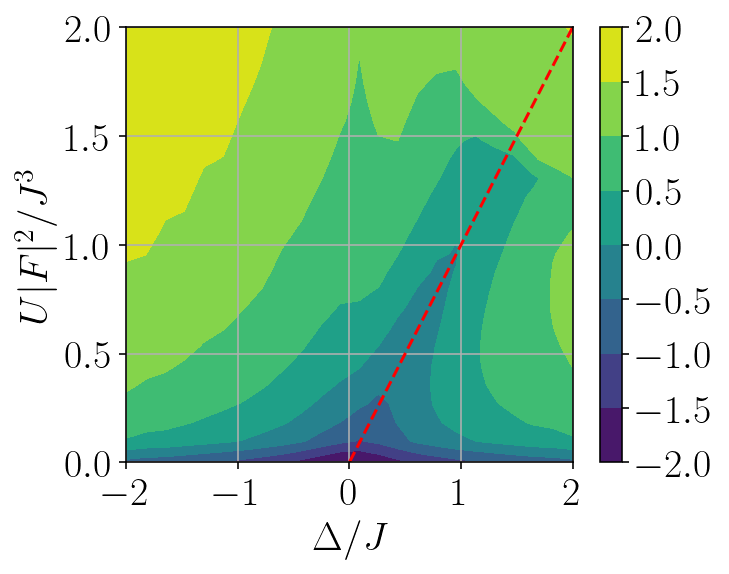

In [22]:
plt.rcParams["figure.figsize"] = [5, 4]
fig, ax = plt.subplots(1, 1)
fs = 20

cp = ax.contourf(Delta_list/J, U*F_list**2/J**3, np.log10(U*np.array(I_T_list)/J)) # , levels=np.arange(0, 5+1, 1)
cbar = fig.colorbar(cp) # , ticks=np.arange(0, 5+1, 1)
cbar.ax.tick_params(labelsize=fs)

ax.set_xticks([-2, -1, 0, 1, 2])

ax.set_xlabel(r'$\Delta/J$',fontsize=fs)
ax.set_ylabel(r'$U|F|^2/J^3$',fontsize=fs)
ax.tick_params(axis='both', labelsize=fs)

ax.plot(Delta_list, Delta_list, '--r')

ax.set_xlim(-1, 1)
ax.set_ylim(0.01, 2)
ax.set_xticks(np.arange(-2, 3, 1))
ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.grid()